# 2. The BlueiceExtendedModel: Fitting and Confidence Intervals
In the previous tutorial we learned about the `BlueiceExtendedModel` and its rate and shape parameters. Now, we'll make use of this knowledge to fit the model to data and compute a confidence interval for the WIMP rate parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from copy import deepcopy

from alea import BlueiceExtendedModel

In [2]:
# Just some plotting settings
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9

## 2.1 Initializing the model & generating data
This is the same as in the previous notebook.

In [3]:
# initialize
config_path = "unbinned_wimp_statistical_model_simple.yaml"
model = BlueiceExtendedModel.from_config(config_path)

# generate and assign data
data = model.generate_data()
model.data = data

Computing/loading models on one core: 100%|██████████| 5/5 [00:00<00:00, 412.57it/s]


## 2.2 Fitting the data

Now that the data is set, we can perform the unconditional fit as in the first example notebook:

In [4]:
best_fit, max_ll = model.fit()
best_fit

{'wimp_mass': 50.0,
 'livetime': 2.0,
 'wimp_rate_multiplier': 0.9696542217012324,
 'er_rate_multiplier': 0.9619885004713751,
 'er_band_shift': -0.08087950892626403}

Let's check the expectation values under the best-fit parameters:

In [5]:
model.get_expectation_values(**best_fit)

{'er': 384.795402562975, 'wimp': 19.393084434024647}

Since we use [iminuit](https://iminuit.readthedocs.io/en/stable/index.html) as a backend for minimizing the likelihood, we can have a look at the very detailed iminuit output, which provides much more information about the fit:

In [6]:
model.minuit_object

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3015                       │              Nfcn = 89               │
│ EDM = 9.81e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                 │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ wimp_mass            │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 1 │ livetime             │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 2 │ wimp_rate_multiplier │   0.97    │   0.30    │            │            │    0    │         │       │
│ 3 │ er_rate_multiplier   │   0.96    │   0.05    │            │            │    0    │         │       │
│ 4 │ er_band_shift        │   -0.08   │   0.08    │            │            │   -2    │    2    │       │
└───┴──────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                      │            wimp_mass             livetime wimp_rate_multiplier   er_rate_multiplier        er_band_shift │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            wimp_mass │                    0                    0                 0.00               0.0000                0.000 │
│             livetime │                    0                    0                 0.00               0.0000                0.000 │
│ wimp_rate_multiplier │                 0.00                 0.00               0.0934              -0.0021                0.005 │
│   er_rate_multiplier │               0.0000               0.0000              -0.0021              0.00237              -0.0002 │
│        er_band_shift │                0.000                0.000                0.005              -0.0002              0.00618 │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────┘

You can see that the parameters, which are not fittable are fixed in the fit to their nominal values. For comparison let's have a look at our parameter definition again:

In [7]:
print(model.parameters)

                      nominal_value  fittable  ptype  uncertainty relative_uncertainty    blueice_anchors fit_limits parameter_interval_bounds  fit_guess                                               description
wimp_mass                      50.0     False   None          NaN                 None               None       None                      None        NaN                                      WIMP mass in GeV/c^2
livetime                        2.0     False   None          NaN                 None               None       None                      None        NaN                                         Livetime in years
wimp_rate_multiplier            1.0      True   rate          NaN                 None               None  [0, None]                   [0, 50]        NaN                                                      None
er_rate_multiplier              1.0      True   rate          0.2                 True               None  [0, None]                      None        1.

To perform a conditional fit, i.e. fix a parameter to a certain value, we can simply parse this value to the `fit`` method with the value of the parameter we want to fix. For example we could perform the background-only fit by fixing the `wimp_rate_multiplier` to 0.

In [8]:
best_fit_c, max_ll_c = model.fit(wimp_rate_multiplier=0.0)
best_fit_c

{'wimp_mass': 50.0,
 'livetime': 2.0,
 'wimp_rate_multiplier': 0.0,
 'er_rate_multiplier': 1.0075851063974377,
 'er_band_shift': -0.21581421284996166}

In [9]:
model.minuit_object

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3036                       │              Nfcn = 37               │
│ EDM = 7.86e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                 │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ wimp_mass            │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 1 │ livetime             │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 2 │ wimp_rate_multiplier │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 3 │ er_rate_multiplier   │   1.01    │   0.05    │            │            │    0    │         │       │
│ 4 │ er_band_shift        │   -0.22   │   0.07    │            │            │   -2    │    2    │       │
└───┴──────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                      │            wimp_mass             livetime wimp_rate_multiplier   er_rate_multiplier        er_band_shift │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            wimp_mass │                    0                    0                    0               0.0000                0.000 │
│             livetime │                    0                    0                    0               0.0000                0.000 │
│ wimp_rate_multiplier │                    0                    0                    0               0.0000                0.000 │
│   er_rate_multiplier │               0.0000               0.0000               0.0000              0.00236               0.0000 │
│        er_band_shift │                0.000                0.000                0.000               0.0000              0.00523 │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [10]:
model.get_expectation_values(**best_fit_c)

{'er': 403.0340491950586, 'wimp': 0.0}

You can nicely see that in the constrained fit, the missing WIMP signal component is absorbed by a higher ER rate and a lower ER shift parameter (shifting the ER band down in cs2 towards the WIMP signals in our toy data).

## 2.3 The ancillary likelihood term

The likelihood used in this model is the sum of a *science run* term and an *ancillary likelihood* term:

In [11]:
model.likelihood_names

['science_run', 'ancillary_likelihood']

The science run term was discussed in some detail in the previous tutorial. Now we'll look at the ancillary likelihood term. You can find in the documentation that this term contains all constraints that you might have on some of the nuisance parameters from ancillary measurements.

In our case we have an uncertainty on the ER rate of 20% on the nominal value. We take this into account by adding a normal distribution centered at 1 (nominal `er_rate_multiplier`) and with a standard deviation of 0.2 (20% uncertainty) to the ancillary likelihood term. Let's have a look:

In [12]:
copied_data = deepcopy(model.data)
# Set ancillary measurement of er_rate_multiplier to nominal value
nominal_er = model.parameters.er_rate_multiplier.nominal_value
copied_data["ancillary_likelihood"]["er_rate_multiplier"][0] = nominal_er

# Assign data with nominal ancillary measurement
model.data = copied_data

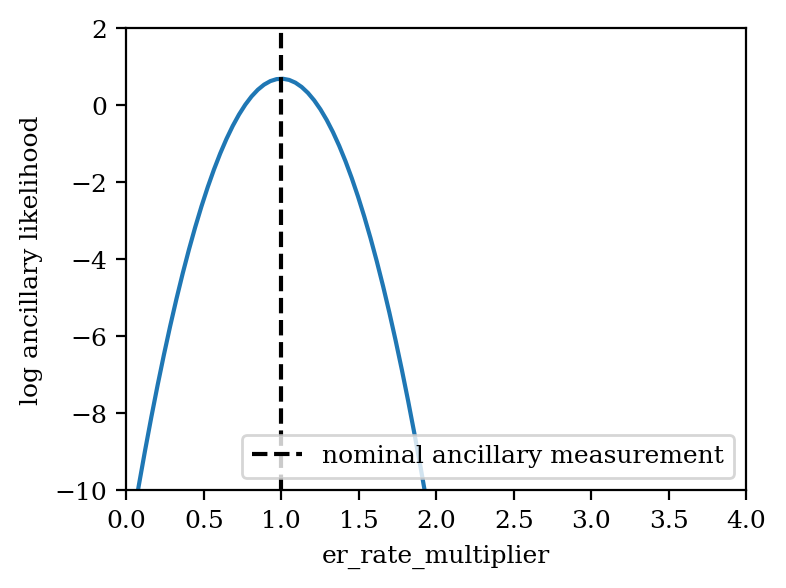

In [13]:
x = np.linspace(0, 4, 100)
y = model.likelihood_list[1].constraint_terms["er_rate_multiplier"](x)
plt.plot(x, y)
plt.axvline(nominal_er, c="k", ls="--", label="nominal ancillary measurement")

# Cosmetics
plt.xlabel("er_rate_multiplier")
plt.ylabel("log ancillary likelihood")
plt.xlim(0, 4)
plt.ylim(-10, 2)
plt.legend()

In each generated toy, the ancillary measurement is varied according to the uncertainty (i.e. in this case measurements are drawn from the normal distribution with mean 1 and standard deviation 0.2). This then shifts the constraint term to the "measured" value. We can illustrate this by artificially assuming a measurement of 2.0 for the ancillary measurement:

In [14]:
# Set ancillary measurement of er_rate_multiplier to 3
copied_data["ancillary_likelihood"]["er_rate_multiplier"][0] = 3.0

# Assign data with nominal ancillary measurement
model.data = copied_data

(-10.0, 2.0)

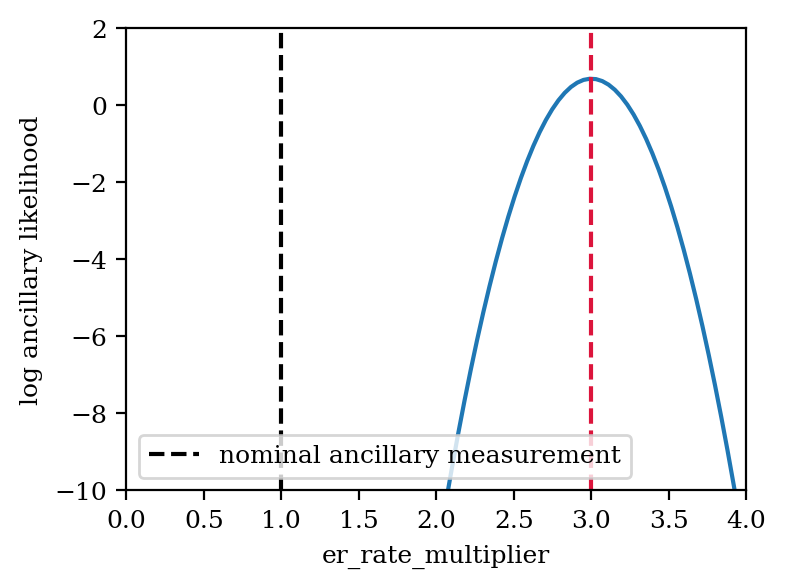

In [15]:
x = np.linspace(0, 4, 100)
y = model.likelihood_list[1].constraint_terms["er_rate_multiplier"](x)
plt.plot(x, y)
plt.axvline(nominal_er, c="k", ls="--", label="nominal ancillary measurement")
plt.axvline(3.0, c="crimson", ls="--")

# Cosmetics
plt.legend()
plt.xlabel("er_rate_multiplier")
plt.ylabel("log ancillary likelihood")
plt.xlim(0, 4)
plt.ylim(-10, 2)

Now let's try fitting this:

In [16]:
best_fit_anc, max_ll_ancc = model.fit()
best_fit_anc

{'wimp_mass': 50.0,
 'livetime': 2.0,
 'wimp_rate_multiplier': 0.8633542451320944,
 'er_rate_multiplier': 1.0970227057452904,
 'er_band_shift': -0.09223467583534711}

In [17]:
model.minuit_object

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3063                       │              Nfcn = 81               │
│ EDM = 4.15e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                 │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ wimp_mass            │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 1 │ livetime             │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 2 │ wimp_rate_multiplier │   0.86    │   0.28    │            │            │    0    │         │       │
│ 3 │ er_rate_multiplier   │   1.10    │   0.05    │            │            │    0    │         │       │
│ 4 │ er_band_shift        │   -0.09   │   0.08    │            │            │   -2    │    2    │       │
└───┴──────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                      │            wimp_mass             livetime wimp_rate_multiplier   er_rate_multiplier        er_band_shift │
├──────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            wimp_mass │                    0                    0                 0.00                0.000                0.000 │
│             livetime │                    0                    0                 0.00                0.000                0.000 │
│ wimp_rate_multiplier │                 0.00                 0.00               0.0813              -0.0020                0.004 │
│   er_rate_multiplier │                0.000                0.000              -0.0020              0.00299              -0.0002 │
│        er_band_shift │                0.000                0.000                0.004              -0.0002              0.00611 │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────┘

The statistics of ER events in the science data set is sufficiently large to pull the ER rate parameter to a value that describes the science data well. Though we can see that due to the constraint term the parameter is pulled towards a larger value compared to the initial fit.

Before we continue, let's revert to our originally generated data set:

In [18]:
model.data = data

## 2.4 Constructing confidence intervals

Now that we have our data and know how to fit (with and without constraint), we can construct a confidence interval on our parameter of interest (POI), which is the `wimp_rate_multiplier` in this case. If we add in the knowledge that a WIMP rate multiplier of 1 corresponds to a WIMP-nucleon cross-section of $10^{-45}\;\mathrm{cm^2}$, we can directly convert this into a confidence interval on the cross-section.

Let's first see how we can compute the confidence interval with the `confidence_interval` method and then replicate the construction of the confidence interval by hand.

In [19]:
ref_xsec = 1e-45  # cm^2
confidence_level = 0.9

In [20]:
lower_limit, upper_limit = model.confidence_interval(
    poi_name="wimp_rate_multiplier", confidence_level=confidence_level
)
lower_limit *= ref_xsec
upper_limit *= ref_xsec

print(
    f"90% CL confidence interval for WIMP-nucleon cross-section: [{lower_limit:.2e}, {upper_limit:.2e}] cm2"
)

90% CL confidence interval for WIMP-nucleon cross-section: [5.36e-46, 1.54e-45] cm2


We use a profile likelihood ratio test statistic to construct our confidence interval. This is defined as:  

$q(s)\equiv -2 \cdot \ln\frac{\mathcal{L}(s, \hat{\hat{\boldsymbol{\theta}}})}{\mathcal{L}(\hat{s}, \hat{{\boldsymbol{\theta}}})}$,  

where the likelihood $\mathcal{L}$ is a function of the WIMP rate multiplier $s\geq 0$ and a set of nuisance parameters $\boldsymbol{\theta}$, which in our case are the ER rate and ER band shift parameters.
The single hat signifies the global maximum likelihood estimator of a parameter, while the double hat corresponds to the nuisance parameters that maximize the likelihood under the constraint that $s$ is fixed to a certain value.

Let's start by computing the test statistic for a few values of $s$:

In [21]:
# unconstrained fit
best_fit, ll_val = model.fit()

# constrained fits
s_vals = np.linspace(0, 2, 200)
ll_vals_c = []
for s in s_vals:
    _, ll_val_c = model.fit(wimp_rate_multiplier=s)
    ll_vals_c.append(ll_val_c)
ll_vals_c = np.array(ll_vals_c)

Text(0, 0.5, '$q(s)$')

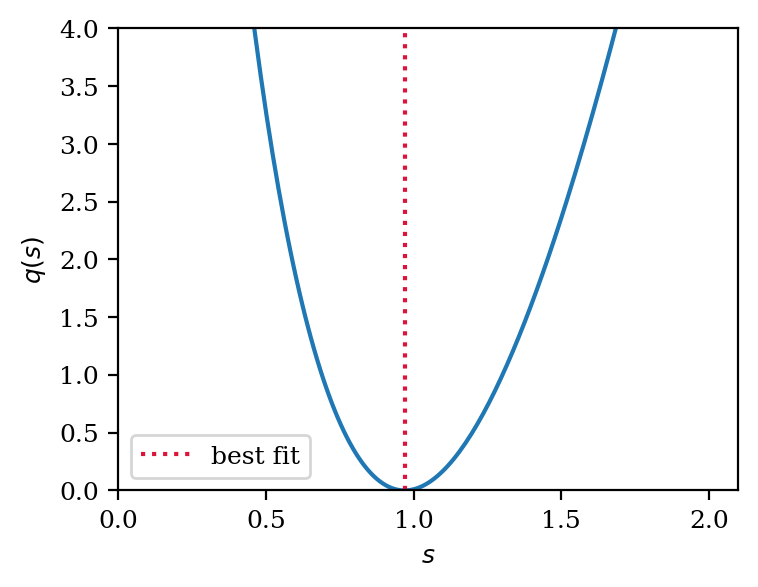

In [22]:
# plot the profile-likelihood scan
plt.plot(s_vals, 2 * (ll_val - ll_vals_c))
plt.axvline(best_fit["wimp_rate_multiplier"], label="best fit", ls=":", color="crimson")

plt.legend()
plt.xlim(0)
plt.ylim(0, 4)
plt.xlabel("$s$")
plt.ylabel("$q(s)$")

To obtain the 90% CL confidence interval we use the fact that in the asymptotic limit, the distribution of $q(s)$ will follow a chi-square distribution with one degree of freedom (for more details refer to [this paper](https://arxiv.org/pdf/1007.1727.pdf) from Cowan et al.). Thus, the critical region for the 90% CL interval is given by the value at which the cumulative distribution function of the chi-square distribution is equal to 0.9. This value is given by the `chi2.ppf` function in `scipy.stats`.

We also apply the linear conversion from the signal rate multiplier $s$ to cross-section $\sigma$ here.

Text(0, 0.5, '$q(\\sigma)$')

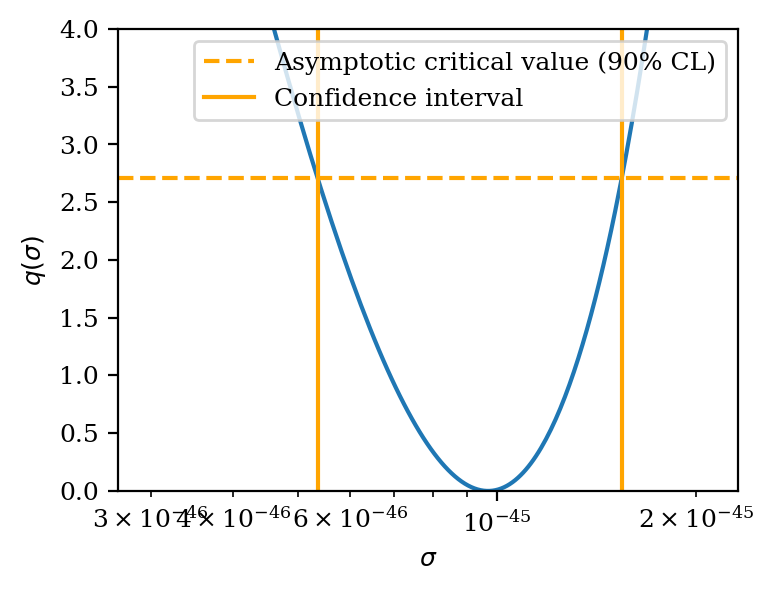

In [23]:
# plot the profile-likelihood scan

plt.plot(s_vals * ref_xsec, 2 * (ll_val - ll_vals_c))
plt.axhline(
    stats.chi2(1).ppf(confidence_level),
    label="Asymptotic critical value (90% CL)",
    c="orange",
    ls="--",
)
plt.axvline(lower_limit, c="orange", label="Confidence interval")
plt.axvline(upper_limit, c="orange")

# Cosmetics
plt.legend()
plt.xlim(lower_limit * 0.5, upper_limit * 1.5)
plt.semilogx()
plt.ylim(0, 4)
plt.xlabel("$\sigma$")
plt.ylabel("$q(\sigma)$")